# Working Example

source: https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb


In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

## Import the dataset
https://github.com/datapythonista/mnist

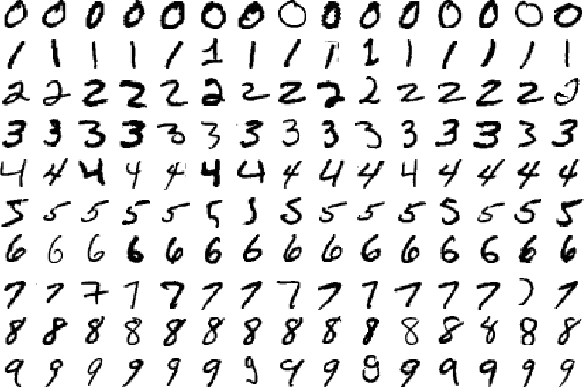

In [2]:
import requests
import gzip
import numpy as np
import os

def fetch_mnist():
    # Use a more reliable mirror
    base_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }
    
    def fetch_file(filename):
        url = base_url + filename
        local_file = os.path.join('data', filename)
        
        # Create data directory if it doesn't exist
        os.makedirs('data', exist_ok=True)
        
        if not os.path.exists(local_file):
            print(f"Downloading {filename}")
            response = requests.get(url)
            response.raise_for_status()
            with open(local_file, 'wb') as f:
                f.write(response.content)
        return local_file

    def load_images(filename):
        local_file = fetch_file(filename)
        with gzip.open(local_file, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
            return data.reshape(-1, 28, 28)
            
    def load_labels(filename):
        local_file = fetch_file(filename)
        with gzip.open(local_file, 'rb') as f:
            return np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    X_train = load_images(files['train_images'])
    Y_train = load_labels(files['train_labels'])
    X_test = load_images(files['test_images'])
    Y_test = load_labels(files['test_labels'])
    

    return X_train, Y_train, X_test, Y_test

# Load the dataset
X_train, Y_train, X_test, Y_test = fetch_mnist()

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  77 254
  107   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19 227 254
  254   9   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  81 254 254
  165   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   7 20

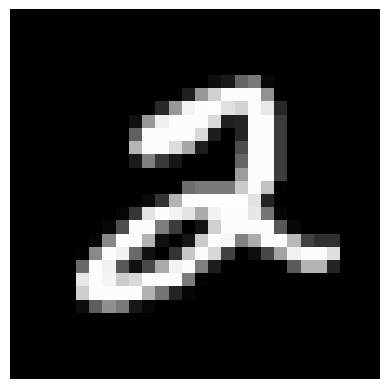

In [22]:
def show_image(image):
    plt.imshow(image, cmap='grey')
    plt.axis('off')  # Hide axis
    plt.show()

print(X_test[5])
show_image(X_train[5])  # Display the first training image

## Build your Model

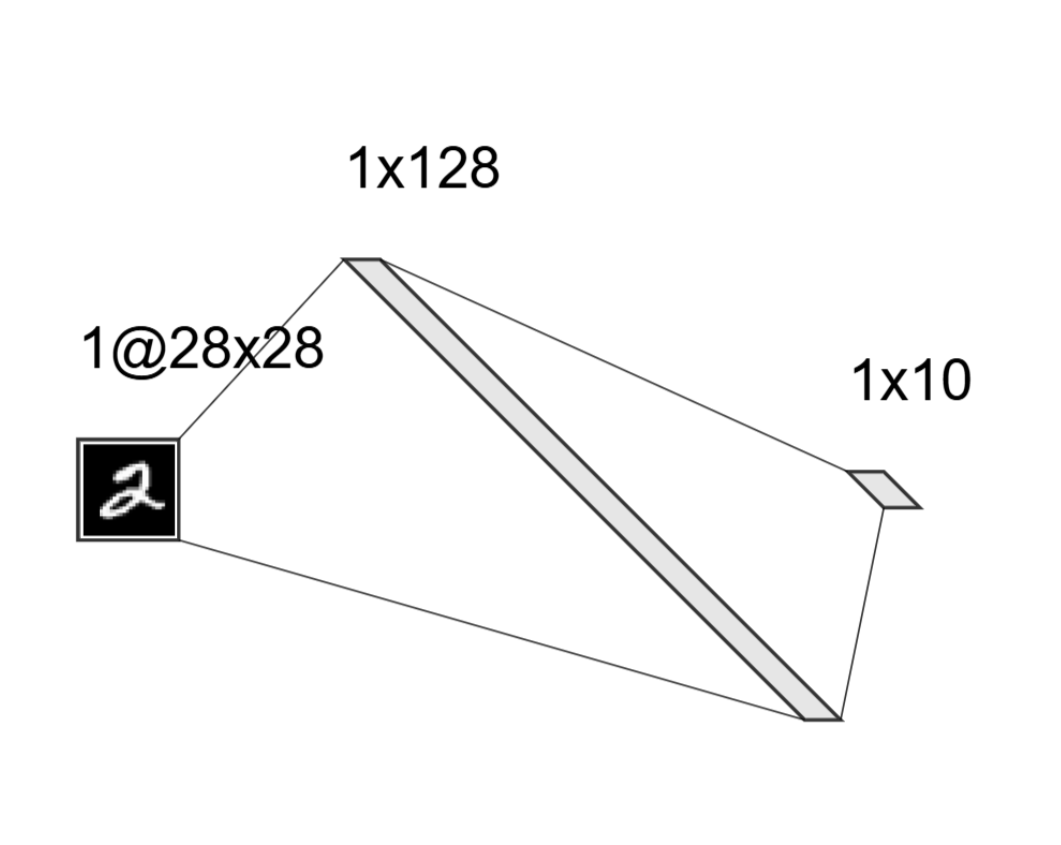


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class convNet(torch.nn.Module):
  def __init__(self, hidden_size=128):  # TODO: play arround with hidden layer size 
    super(convNet, self).__init__()
    self.l1 = nn.Linear(28 * 28, hidden_size, bias=False)  # Input (28*28) is the pixel resolution of MNIST images
    self.l2 = nn.Linear(hidden_size, 10, bias=False)  # Output 10 possible digits to detect
    self.sm = nn.LogSoftmax(dim=1)
  
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

loss 0.06 accuracy 0.97: 100%|██████████| 10000/10000 [00:26<00:00, 372.07it/s]


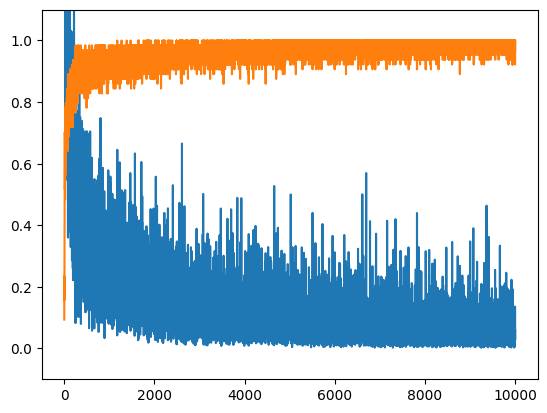

In [54]:
# make an instance of your model
model = convNet()

# Training Parameters
batch_size = 64  # number of training samples per cycle
epoch = 10000     # number of training cycles

'''
What are common loss functions?

For a multi-class classification problems, like guessing which number is written, the loss function could be:
- Negative Log Likelihood Loss (NLLLoss) this is the one implemented below
- Categorical Cross Entropy (CCE) 
''' 
loss_function = nn.NLLLoss(reduction='none')

'''
What are common loss optimizers?

For training neural networks, common optimizers include:
- Stochastic Gradient Descent (SGD): A simple and widely used optimizer that updates weights based on the gradient of the loss function.
- Adam: An adaptive learning rate optimizer that combines the advantages of two other extensions of SGD.
''' 
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.01)

losses, accuracies = [], []

# THE TRAINING LOOP
for i in (t := trange(epoch)):
    # Sample a random batch of training data
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()  # Reshape images for input
    Y = torch.tensor(Y_train[samp]).long()  # Convert labels to long tensor

    model.zero_grad()  # Clear previous gradients
    
    out = model(X)  # Forward pass: compute predicted outputs

    cat = torch.argmax(out, dim=1)  # Get predicted class labels

    accuracy = (cat == Y).float().mean()  # Calculate accuracy

    loss = loss_function(out, Y)  # Compute the loss
    loss = loss.mean()  # Average the loss over the batch
    loss.backward()  # Backward pass: compute gradients

    optim.step()  # Update model parameters

    loss, accuracy = loss.item(), accuracy.item()  # Convert to Python scalars

    losses.append(loss)  # Store loss for plotting
    accuracies.append(accuracy)  # Store accuracy for plotting

    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))  # Update progress bar

# Plot the Training Progress
plt.ylim(-0.1, 1.1)
plt.plot(losses)  # Plot loss over epochs
plt.plot(accuracies)  # Plot accuracy over epochs

In [65]:
# Playground to test out model inference

import cv2
from PIL import Image

# Function to capture user drawing
def draw_digit():
    # Create a black canvas
    canvas = np.zeros((280, 280), dtype=np.uint8)  # 280x280 pixels for better drawing (black background)
    drawing = False

    def draw_circle(event, x, y, flags, param):
        nonlocal drawing
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = not drawing  # Toggle drawing on mouse button down
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                cv2.circle(canvas, (x, y), 10, 255, -1)  # Draw white circle (pen color)
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False  # Stop drawing when mouse button is released

    # Create a window and set the mouse callback
    cv2.namedWindow("Draw a digit (0-9) and press Enter")
    cv2.setMouseCallback("Draw a digit (0-9) and press Enter", draw_circle)

    while True:
        cv2.imshow("Draw a digit (0-9) and press Enter", canvas)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Enter key
            break
        if key == 27:  # Escape key to exit
            cv2.destroyAllWindows()
            return None

    # Save the drawn image
    img = Image.fromarray(canvas)
    img = img.resize((28, 28), Image.LANCZOS)  # Resize to 28x28
    img = img.convert('L')  # Convert to grayscale
    img = np.array(img)  # Convert to NumPy array
    img = img.reshape(1, -1)  # Reshape for model input array (28x28) to vector (1x784)

    cv2.destroyAllWindows()  # Close the OpenCV window
    return img

# Function to predict the drawn digit
def predict_digit(model):
    drawn_image = draw_digit()
    if drawn_image is not None:
        with torch.no_grad():  # Disable gradient calculation
            output = model(torch.tensor(drawn_image).float())
            prediction = torch.argmax(output, dim=1).item()  # Get predicted class
        print(f"Predicted digit: {prediction}")

# Call the prediction function
predict_digit(model)

Predicted digit: 7
